In [1]:
# Import system utilities and set module path
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

# Import PyTorch utilities
import torch
from torch.utils.data import DataLoader

# Import dataset handling
from torchgeo.datasets import NAIP, stack_samples

In [2]:
# Import project configs and data handlers
from datetime import datetime

import matplotlib.patches as mpatches

# Import visualization and utility tools
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from matplotlib.colors import ListedColormap

from configs import config
from data.kc import KaneCounty
from data.sampler import BalancedRandomBatchGeoSampler

In [3]:
# Load NAIP dataset
naip_dataset = NAIP("/net/projects/cmap/data/KC-images")

# Define path to shape file
shape_path = Path(config.KC_SHAPE_ROOT) / config.KC_SHAPE_FILENAME

# Define dataset configuration using config parameters
dataset_config = (
    config.KC_LAYER,
    config.KC_LABELS,
    config.PATCH_SIZE,
    naip_dataset.crs,
    naip_dataset.res,
)

# Initialize Kane County dataset
kc_dataset = KaneCounty(shape_path, dataset_config)

# Merge NAIP dataset with Kane County dataset
train_dataset = naip_dataset & kc_dataset

context_size: 154
patch_size: 512
res: 0.6


In [4]:
# Create a balanced random batch sampler for training
train_sampler = BalancedRandomBatchGeoSampler(
    config={
        "dataset": train_dataset,
        "size": config.PATCH_SIZE,
        "batch_size": 1,
    }
)

# DataLoader for visualizing training samples
plot_dataloader = DataLoader(
    dataset=train_dataset,
    batch_sampler=train_sampler,
    collate_fn=stack_samples,
    num_workers=config.NUM_WORKERS,
)

In [5]:
# Iterate through the dataloader and print the shapes of image and mask tensors,
MAX_BATCHES = 2
EXPECTED_DIM = 3
SINGLE_CHANNEL = 1
RGB_CHANNELS = 3

for batch, sample in enumerate(plot_dataloader):
    print(sample["image"].shape, sample["mask"].shape)
    if batch > MAX_BATCHES:
        break

torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])


In [6]:
# --- Create a custom colormap from kc_dataset.colors ---
# Sort the keys so that the colormap is consistent
sorted_keys = sorted(kc_dataset.colors.keys())
# Normalize the colors (RGB only) to [0,1]
color_list = [tuple(np.array(kc_dataset.colors[k][:3]) / 255.0) for k in sorted_keys]
custom_cmap = ListedColormap(color_list)

# --- Extract one sample from the dataloader ---
sample = next(iter(plot_dataloader))
img_tensor = sample["image"][0]  # shape: (channels, height, width)
mask_tensor = sample["mask"][0]  # shape: (height, width) or (1, height, width)

if mask_tensor.dim() == EXPECTED_DIM and mask_tensor.shape[0] == SINGLE_CHANNEL:
    mask_tensor = mask_tensor.squeeze(0)

In [7]:
# Use only the first 3 channels for RGB visualization
img_rgb = (
    img_tensor[:RGB_CHANNELS] if img_tensor.shape[0] >= RGB_CHANNELS else img_tensor
)

# Rearrange the image to (height, width, channels) and convert to NumPy uint8
img_rgb_np = rearrange(img_rgb, "c h w -> h w c").cpu().numpy().astype("uint8")
# Convert mask to NumPy array for plotting
mask_np = mask_tensor.cpu().numpy()

(-0.5, 511.5, 511.5, -0.5)

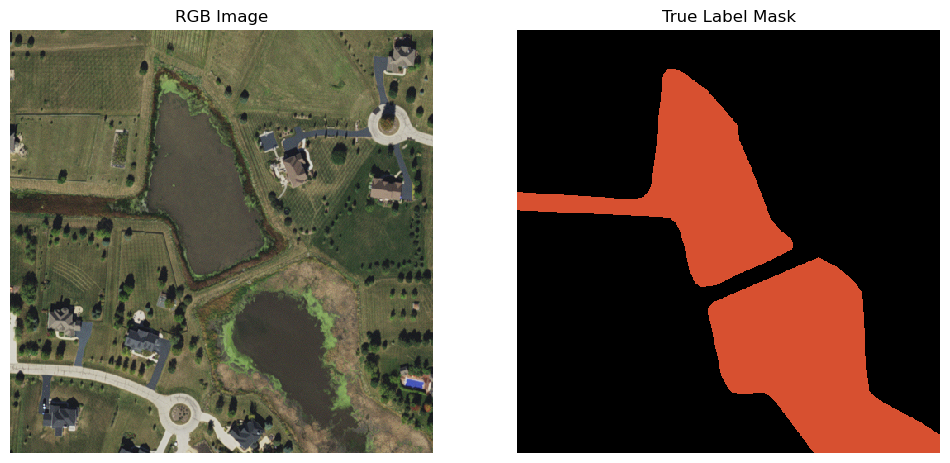

In [ ]:
# --- Create two subplots: RGB Image & True Label Mask ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 1. Display RGB Image (No Mask Overlay)
axs[0].imshow(img_rgb_np, interpolation="none")
axs[0].set_title("RGB Image")
axs[0].axis("off")

# 2. Display True Label Mask (solid colors, no alpha blending)
axs[1].imshow(
    mask_np, cmap=custom_cmap, interpolation="none", vmin=0, vmax=len(sorted_keys) - 1
)
axs[1].set_title("True Label Mask")
axs[1].axis("off")

In [9]:
# --- Create a legend for the True Label Mask ---
legend_handles = []
unique_vals_in_mask = set(
    np.unique(mask_np)
)  # Only include labels that appear in the image

for k in sorted_keys:
    if k in unique_vals_in_mask:
        label_name = kc_dataset.labels_inverse.get(k, str(k))
        color = tuple(np.array(kc_dataset.colors[k][:3]) / 255.0)
        patch = mpatches.Patch(color=color, label=label_name)
        legend_handles.append(patch)

In [10]:
# Add legend below the True Label Mask (only for present labels)
if legend_handles:
    fig.legend(
        handles=legend_handles, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.1)
    )

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# Segmentation code:

In [11]:
# Ensure the module path is correctly added
sys.path.append("/home/gregoryc25/CMAP/segment_anything_source_code")

# Import necessary components
from segment_anything.build_sam import sam_model_registry
from segment_anything.predictor import SamPredictor

# Define checkpoint path
home_dir = Path.home()
sam_checkpoint = home_dir / "CMAP/segment_anything_source_code/sam_vit_h.pth"

# Ensure the checkpoint file exists
if not sam_checkpoint.exists():
    raise FileNotFoundError(f"Checkpoint file not found: {sam_checkpoint}")

# Load the model
sam = sam_model_registry["vit_h"](
    checkpoint=str(sam_checkpoint)
)  # Ensure the path is a string
predictor = SamPredictor(sam)

In [12]:
# 1) Get unique values from the mask (excluding background=0)
unique_vals = torch.unique(mask_tensor)
valid_labels = unique_vals[unique_vals > 0]  # Exclude background (0)

if len(valid_labels) == 0:
    raise ValueError("No valid foreground labels found!")

# 2) Pick a random label from the valid set
random_label_idx = torch.randint(0, len(valid_labels), (1,)).item()
chosen_label = valid_labels[random_label_idx].item()

# 3) Gather all pixel coordinates of the chosen label
ys, xs = torch.where(mask_tensor == chosen_label)

In [13]:
if len(xs) > 0 and len(ys) > 0:
    # 4) Pick a random point within that label
    random_index = torch.randint(0, len(xs), (1,)).item()
    seed_x = xs[random_index].item()
    seed_y = ys[random_index].item()

    print(f"Selected label: {chosen_label}")
    print(f"Seed coordinate: (x={seed_x}, y={seed_y})")

    # Sanity check
    if mask_tensor[seed_y, seed_x] != chosen_label:
        raise ValueError("Seed point not inside the chosen label!")
else:
    raise ValueError("No valid pixel found for chosen label!")

Selected label: 1
Seed coordinate: (x=266, y=168)


In [14]:
# Ensure we're using the same stored seed point
print(f"Using  segmentation seed coordinate: (x={seed_x}, y={seed_y})")

# Create the seed coordinate array in the expected shape (1, 2)
seed_coordinate = np.array([[seed_x, seed_y]])
seed_label = np.array([1])  # Positive prompt

# Set the image before predicting
predictor.set_image(img_rgb_np)

# --- Call the SAM predictor with the **same seed** ---
masks, scores, logits = predictor.predict(
    point_coords=seed_coordinate,
    point_labels=seed_label,
    multimask_output=False,  # Single best mask
)

# Select the **highest scoring mask**
best_mask = masks[0]
best_score = scores[0]

Using  segmentation seed coordinate: (x=266, y=168)


(-0.5, 511.5, 511.5, -0.5)

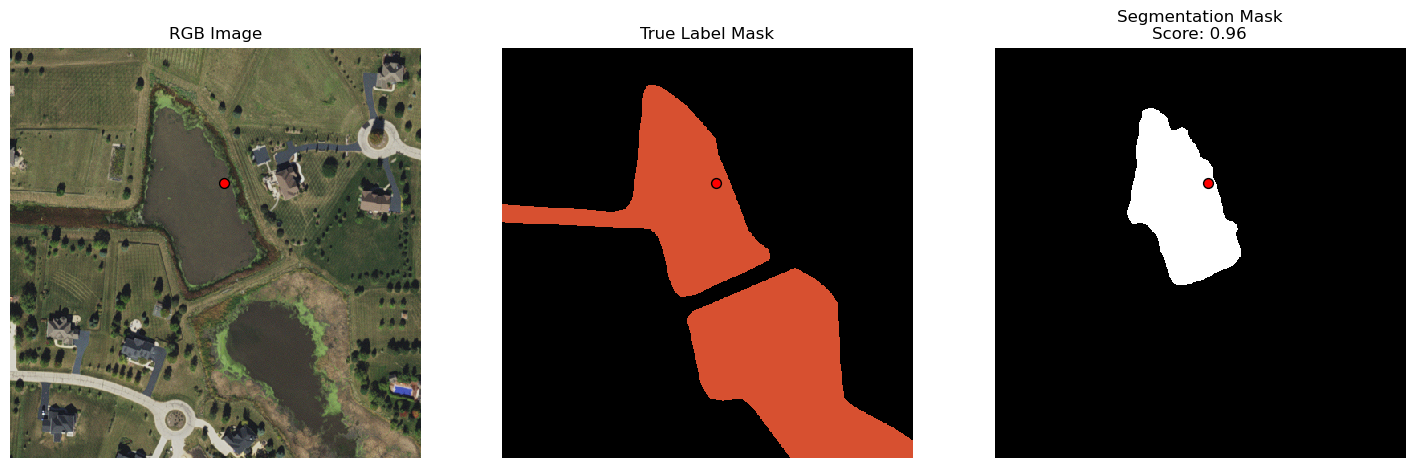

In [15]:
# --- Create Three Subplots: RGB, True Label Mask, Segmentation Mask ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Display RGB Image with Seed Point
axs[0].imshow(img_rgb_np, interpolation="none")
axs[0].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[0].set_title("RGB Image")
axs[0].axis("off")

# 2. Display True Label Mask with Seed Point (Solid Colors)
axs[1].imshow(
    mask_np, cmap=custom_cmap, interpolation="none", vmin=0, vmax=len(sorted_keys) - 1
)

axs[1].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[1].set_title("True Label Mask")
axs[1].axis("off")

# 3. Display Best Segmentation Mask with Seed Point
axs[2].imshow(best_mask, cmap="gray", interpolation="none")
axs[2].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[2].set_title(f"Segmentation Mask\nScore: {best_score:.2f}")
axs[2].axis("off")

In [16]:
output_folder = home_dir / "CMAP/segment-anything/kc_sam_outputs"
output_folder.mkdir(parents=True, exist_ok=True)

# Generate a unique filename (timestamp-based)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = output_folder / f"segmentation_{timestamp}.png"

# Save the figure
plt.savefig(output_path, bbox_inches="tight", dpi=300)

plt.tight_layout()
plt.show()

print(f"Saved segmentation result to: {output_folder}")

<Figure size 640x480 with 0 Axes>

Saved segmentation result to: /home/gregoryc25/CMAP/segment-anything/kc_sam_outputs


In [17]:
# Per-class & Instance IoU
sys.path.append(str(Path("..").resolve()))
from utils.kc_visualizations_helper import compute_instance_iou

# Instance IoU
iou_instance = compute_instance_iou(best_mask, mask_np, chosen_label)
print(f"Instance {chosen_label} IoU: {iou_instance:.4f}")

Instance 1 IoU: 0.2828


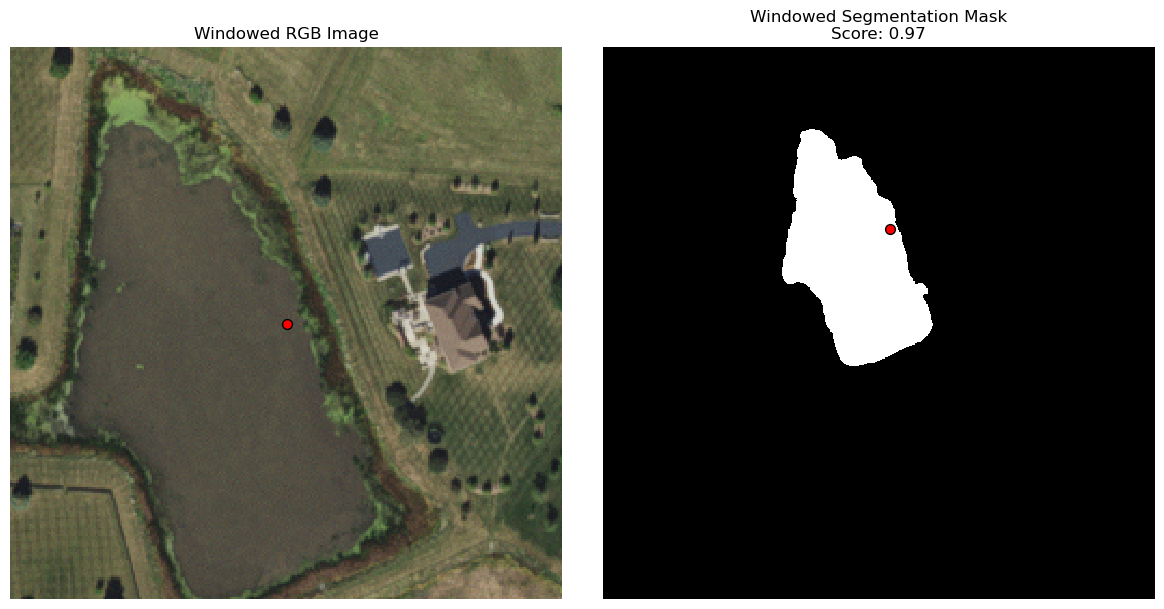

Windowed Instance 1 IoU: 0.6788


In [18]:
# ----- Cell: Windowing Segmentation Experiment -----
# Define a window size 
window_size = 256 

# Center the window around seed point
half_window = window_size // 2
h, w, _ = img_rgb_np.shape
x0 = max(0, seed_x - half_window)
y0 = max(0, seed_y - half_window)
x1 = min(w, seed_x + half_window)
y1 = min(h, seed_y + half_window)

# Extract windowed image
window_img = img_rgb_np[y0:y1, x0:x1]

# Set  image in  SAM predictor to  windowed image
predictor.set_image(window_img)

# Compute  seed coordinates relative to  window
seed_x_window = seed_x - x0
seed_y_window = seed_y - y0
seed_coordinate_window = np.array([[seed_x_window, seed_y_window]])

# Run SAM prediction on  window
masks_window, scores_window, _ = predictor.predict(
    point_coords=seed_coordinate_window,
    point_labels=seed_label,
    multimask_output=False,
)
best_mask_window = masks_window[0]
best_score_window = scores_window[0]

# Paste the window mask back into a blank mask for  full image
segmentation_mask_windowed = np.zeros((h, w), dtype=best_mask_window.dtype)
segmentation_mask_windowed[y0:y1, x0:x1] = best_mask_window

# Plot  windowed image and resulting segmentation
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(window_img, interpolation="none")
axs[0].scatter(seed_x_window, seed_y_window, color="red", s=50, marker="o", edgecolors="black")
axs[0].set_title("Windowed RGB Image")
axs[0].axis("off")

axs[1].imshow(segmentation_mask_windowed, cmap="gray", interpolation="none")
axs[1].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[1].set_title(f"Windowed Segmentation Mask\nScore: {best_score_window:.2f}")
axs[1].axis("off")
plt.tight_layout()
plt.show()

# Compute IoU over  window region (compare only within the window)
iou_instance_window = compute_instance_iou(best_mask_window, mask_np[y0:y1, x0:x1], chosen_label)
print(f"Windowed Instance {chosen_label} IoU: {iou_instance_window:.4f}")


In [ ]:
# ----- Cell: Contrast-Enhanced Segmentation Experiment -----
import cv2  # Ensure OpenCV is installed

# Convert the original RGB image to YCrCb color space for contrast enhancement
img_ycrcb = cv2.cvtColor(img_rgb_np, cv2.COLOR_RGB2YCrCb)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_ycrcb[:, :, 0] = clahe.apply(img_ycrcb[:, :, 0])
img_contrast_enhanced = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2RGB)

# Use the contrast-enhanced image for segmentation
predictor.set_image(img_contrast_enhanced)
masks_contrast, scores_contrast, _ = predictor.predict(
    point_coords=seed_coordinate,
    point_labels=seed_label,
    multimask_output=False,
)
best_mask_contrast = masks_contrast[0]
best_score_contrast = scores_contrast[0]

# Plot original image, contrast-enhanced image, and segmentation result
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img_rgb_np, interpolation="none")
axs[0].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[0].set_title("Original RGB Image")
axs[0].axis("off")

axs[1].imshow(img_contrast_enhanced, interpolation="none")
axs[1].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[1].set_title("Contrast-Enhanced RGB Image")
axs[1].axis("off")

axs[2].imshow(best_mask_contrast, cmap="gray", interpolation="none")
axs[2].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[2].set_title(f"Segmentation on Contrast Image\nScore: {best_score_contrast:.2f}")
axs[2].axis("off")
plt.tight_layout()
plt.show()

# Compute IoU for the segmentation on the contrast-enhanced image
iou_instance_contrast = compute_instance_iou(best_mask_contrast, mask_np, chosen_label)
print(f"Contrast-enhanced Instance {chosen_label} IoU: {iou_instance_contrast:.4f}")


In [ ]:
# ----- Cell: Multiple Windowing Examples -----
import numpy as np

num_examples = 3  # Number of examples to show
window_size = 256  # Window size (adjust as needed)
half_window = window_size // 2
h, w, _ = img_rgb_np.shape

# Get all valid pixel coordinates for the chosen label
ys, xs = torch.where(mask_tensor == chosen_label)
ys_np = ys.cpu().numpy()
xs_np = xs.cpu().numpy()

for i in range(num_examples):
    # Pick a random seed coordinate within the chosen label
    random_index = np.random.randint(0, len(xs_np))
    seed_x = xs_np[random_index]
    seed_y = ys_np[random_index]
    
    # Define window boundaries centered on this new seed
    x0 = max(0, seed_x - half_window)
    y0 = max(0, seed_y - half_window)
    x1 = min(w, seed_x + half_window)
    y1 = min(h, seed_y + half_window)
    
    # Extract the windowed image from the full RGB image
    window_img = img_rgb_np[y0:y1, x0:x1]
    
    # Set the predictor to use the windowed image
    predictor.set_image(window_img)
    
    # Compute the seed coordinates relative to the window
    seed_x_window = seed_x - x0
    seed_y_window = seed_y - y0
    seed_coordinate_window = np.array([[seed_x_window, seed_y_window]])
    
    # Run SAM prediction on the window
    masks_window, scores_window, _ = predictor.predict(
         point_coords=seed_coordinate_window,
         point_labels=seed_label,
         multimask_output=False,
    )
    best_mask_window = masks_window[0]
    best_score_window = scores_window[0]
    
    # Paste the window mask back into a blank full-image mask
    segmentation_mask_windowed = np.zeros((h, w), dtype=best_mask_window.dtype)
    segmentation_mask_windowed[y0:y1, x0:x1] = best_mask_window
    
    # Compute IoU over the window region only
    iou_instance_window = compute_instance_iou(best_mask_window, mask_np[y0:y1, x0:x1], chosen_label)
    
    # Plot the windowed image and the windowed segmentation mask overlay on the full image
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the windowed (zoomed) RGB patch with the seed point
    axs[0].imshow(window_img, interpolation="none")
    axs[0].scatter(seed_x_window, seed_y_window, color="red", s=50, marker="o", edgecolors="black")
    axs[0].set_title(f"Example {i+1}: Windowed RGB")
    axs[0].axis("off")
    
    # Display the full image with the segmentation mask from the window
    axs[1].imshow(segmentation_mask_windowed, cmap="gray", interpolation="none")
    axs[1].scatter(seed_x, seed_y, color="red", s=50, marker="o", edgecolors="black")
    axs[1].set_title(f"Example {i+1}: Segmentation (Score: {best_score_window:.2f})")
    axs[1].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Example {i+1} - Windowed Instance {chosen_label} IoU: {iou_instance_window:.4f}\n")
